In [1]:
%matplotlib notebook
import os

import cv2
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../vae/')
from VAE import VAE
from tqdm import tnrange, tqdm_notebook

# Clustered classes and their inverse mappings

In [2]:
clustered_classes = []
mapping_classes_index = dict()
clustered_classes_count = []
file_name = 'class_clusters.txt'
with open(file_name, 'rt') as file:
    lines = file.read().splitlines()
    idx = -1
    for line in lines:
        words = line.split('\t')
        if not line.startswith('\t'):
            clustered_classes.append(set())
            clustered_classes_count.append(0)
            idx += 1
        class_name = line.strip().split('\t')[0]
        mapping_classes_index[class_name] = idx
        clustered_classes_count[idx] += int(line.strip().split('\t')[-1])
        clustered_classes[idx].add(class_name)

In [3]:
from pprint import pprint
class_with_count = list(zip(clustered_classes, clustered_classes_count))
class_with_count.sort(key=lambda x: x[1], reverse=True)

In [4]:
from math import ceil
filtered_classes = [x[0] for i,x in enumerate(class_with_count) if x[1]>500]
filtered_classes_count = [x[1] for i,x in enumerate(class_with_count) if x[1]>500]
mapping_filtered_classes = dict()
for i,classes in enumerate(filtered_classes):
    for c in classes:
        mapping_filtered_classes[c] = i

clustered_classes = filtered_classes
clustered_classes_count = filtered_classes_count

mapping_classes_index = mapping_filtered_classes

NUM_CLASSES = len(clustered_classes)
NUM_BYTES_FOR_MASK = NUM_CLASSES+1
print(NUM_CLASSES, NUM_BYTES_FOR_MASK)

24 25


In [5]:
print('\n'.join([', '.join(x)+': '+str(y) for x,y in zip(clustered_classes, clustered_classes_count)]))

Woman, Girl, Human body, Man, Boy, Person: 44429
Hair, Ear, Mouth, Beard, Arm, Nose, Face, Leg, Head, Eye, Hand: 24164
Trousers, Tie, Shirt, Jacket, Brassiere, Coat, Dress, Jeans, Suit, Skirt, Shorts, Clothing: 18591
Vehicle, Licence plate, Bus, Tire, Motorcycle, Land vehicle, Bike, Auto part, Wheel, Bicycle wheel, Car, Tank, Truck, Taxi, Train, Van: 13831
Wine glass, Tin can, Cocktail, Beer, Juice, Bottle, Coffee, Wine, Drink: 8164
Muffin, Pastry, Sandwich, Dairy, Cake, Vegetable, Snack, Squash, Pumpkin, Tomato, Salad, Fast food, Ice cream, Mushroom, Food, Baked goods, Seafood, Bread, Pizza, Fruit, Strawberry, Dessert: 4988
High heels, Sandal, Boot, Footwear: 4774
Monkey, Cat, Elephant, Horse, Turtle, Mammal, Bear, Squirrel, Carnivore, Dog, Lion, Cattle, Animal, Tortoise, Deer, Lizard, Sheep, Reptile, Frog: 3137
Television, Mobile phone, Computer keyboard, Camera, Laptop, Computer monitor: 3056
Sofa bed, Drawer, Pillow, Couch, Kitchen appliance, Bookcase, Lamp, Shelf, Sink, Chair, Ben

# Retreive images from dataset

In [6]:
class ImageManager:
    def __init__(self, folder_path, td_output_dir, od_output_dir, npy_data_dir, start, end, overwrite=False):
        self.start = start
        self.end = end
        self.folder_path = folder_path
        self.overwrite = overwrite
        self.od_output_dir = od_output_dir
        self.td_output_dir = td_output_dir
        self.npy_data_dir = npy_data_dir
        self.index = 0
        self.files = self.resized_images()
        self.totalFiles = len(self.files)

    def next_batch(self, batch_size):
        start = self.index
        self.index += batch_size
        if self.index > self.totalFiles:
            self.index = 0
            file_order = np.arange(self.totalFiles)
            np.random.shuffle(file_order)
            self.files = self.files[file_order]
            start = 0
            self.index = batch_size
        return self.files[start : self.index]

    def get_images_and_masks(self, i):
#         print('Reading:', i)
        path = os.path.join(self.folder_path, str(i))
        file_names = os.listdir(path)
        masks = np.zeros((len(file_names), 100, 100, NUM_BYTES_FOR_MASK), np.uint8)
        delete_mask = []
        for idx, file_name in enumerate(tqdm_notebook(file_names,desc='Read:'+str(i))):
            name = os.path.basename(file_name).split('.')[0]
            td_output_file = os.path.join(self.td_output_dir, str(i), name)+'.txt'
            od_output_file = os.path.join(self.od_output_dir, str(i), name)+'.txt'
            if file_name.endswith('.jpg') and (os.path.isfile(td_output_file) 
                                               or os.path.isfile(od_output_file)):
#                 orig_img = cv2.imread(os.path.join(path, file_name))
#                 masks[idx, :, :, :3] = cv2.resize(orig_img, (100, 100))
                orig_img = Image.open(os.path.join(path, file_name))
#                 print(orig_img.size)
                
                if os.path.isfile(td_output_file):
                    with open(td_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            coord = [int(x) for x in line.split(',')]
                            img_width, img_height = masks[idx].shape[0],masks[idx].shape[1]
                            l = round(coord[0]*img_width/orig_img.size[0])
                            r = round(coord[2]*img_width/orig_img.size[0])
                            t = round(coord[1]*img_height/orig_img.size[1])
                            b = round(coord[-1]*img_height/orig_img.size[1])
#                             l = round(coord[0]*img_width/orig_img.shape[1])
#                             r = round(coord[2]*img_width/orig_img.shape[1])
#                             t = round(coord[1]*img_height/orig_img.shape[0])
#                             b = round(coord[-1]*img_height/orig_img.shape[0])
                            masks[idx,t:b,l:r,0] = 1
                            
                if os.path.isfile(od_output_file):       
                    with open(od_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            try:
                                class_idx = mapping_classes_index[
                                    line.split(':')[0].split(',')[-1]]+1
#                                 print(class_idx, line.split(':')[0].split(',')[-1])
                                coord = line.split(':')[1].split(',')
                                coord = [round(float(x)*masks[idx].shape[(j+1)%2]) for j,x in enumerate(coord)]
#                                 masks[idx,coord[0]:coord[2],coord[1]:coord[3],
#                                       (class_idx//8)-1] += 1<<(class_idx%8)
                                masks[idx,coord[0]:coord[2],coord[1]:coord[3],
                                      class_idx] = 1
                            except KeyError:
#                                 print('Keyerror',line.split(':')[0].split(',')[-1])
                                pass
            else:
                delete_mask.append(idx)
                
        np.delete(masks, delete_mask)
        if not os.path.exists(self.npy_data_dir):
            os.makedirs(self.npy_data_dir)
        np.save(os.path.join(self.npy_data_dir, str(i)), masks)
#         print('Saved:',os.path.join(self.npy_data_dir, str(i)),'\nNumber of files',masks.shape[0])
        return masks
        
    def resized_images(self):
        final_masks = None
        for i in tqdm_notebook(range(self.start, self.end), desc='1st loop'):
            if not os.path.isfile(os.path.join(self.npy_data_dir, str(i))+'.npy') or self.overwrite:
                masks = self.get_images_and_masks(i)
            else:
                masks = np.load(os.path.join(self.npy_data_dir, str(i))+'.npy')
#                 print('Loaded:',os.path.join(self.npy_data_dir, str(i))+'.npy','\nNumber of files',masks.shape)
#             masks = masks.reshape(masks.shape[0], -1).astype(np.float16)
            if final_masks is None:
                final_masks = masks
            else:
                final_masks = np.append(final_masks,masks,axis=0)
        return final_masks

In [7]:
%%time
IMAGES_PATH = '/gpfs/scratch/asamanta/dataset/train_images/'
TEXT_DET_OUTPUT = '../../../td-output/'
OBJECT_DET_OUTPUT = '../../../od-output/'
NUMPY_DATA = '/gpfs/scratch/asamanta/dataset/numpy-data-with-mask-per-layers/'
OUT_TF_DATA = '/gpfs/scratch/asamanta/'

image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 0, 7)
test_image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 7, 11)

A Jupyter Widget

A Jupyter Widget


CPU times: user 8.22 s, sys: 15.3 s, total: 23.5 s
Wall time: 25.5 s


# Visualize one image and its masks

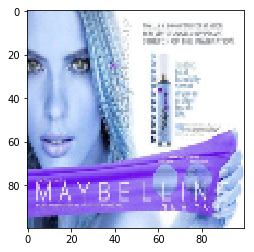

Layer: Text


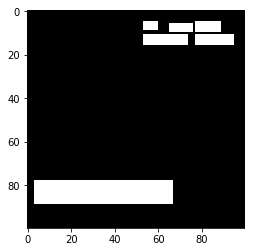

Layer: {'Woman', 'Girl', 'Human body', 'Man', 'Boy', 'Person'}


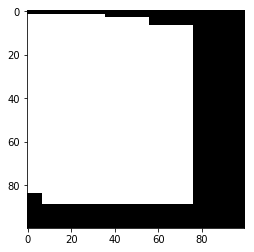

Layer: {'Hair', 'Ear', 'Mouth', 'Beard', 'Arm', 'Nose', 'Face', 'Leg', 'Head', 'Eye', 'Hand'}


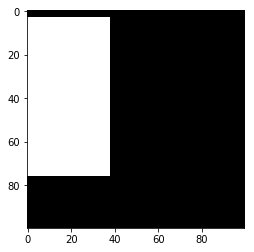

In [8]:
%matplotlib inline
img_mask = image_manager.files[5].reshape([100, 100, NUM_BYTES_FOR_MASK])
folder_path = os.path.join(image_manager.folder_path, '0')
img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[5]))
img = cv2.resize(img, (100,100))

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
print('Layer: Text')
plt.imshow(img_mask[:,:,0], origin="upper", cmap="gray")
plt.show()
        
for i in range(1,NUM_BYTES_FOR_MASK):
    if np.count_nonzero(img_mask[:,:,i])>0:
        print('Layer:',clustered_classes[i-1])
        fig = plt.figure()
        plt.imshow(img_mask[:,:,i], origin="upper", cmap="gray")
        plt.show()

# BETA VARIATIONAL AUTOENCODER

In [51]:
# Parameters

tf.reset_default_graph()

learning_rate = 1e-4
num_steps = 1
batch_size = 16
# Network Parameters
NUM_BYTES_FOR_MASK = 3+1
image_dim = 100*100*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 1024
hidden_dim2 = 128
latent_dim = 16
n_samples = image_manager.files.shape[0]
beta = 4
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [52]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim1])),
    'encoder_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim2])),
    'decoder_h2': tf.Variable(glorot_init([hidden_dim2, hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim1, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim1])),
    'encoder_b2': tf.Variable(glorot_init([hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim2])),
    'decoder_b2': tf.Variable(glorot_init([hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [53]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim], name='input')
encoder1 = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder1 = tf.nn.leaky_relu(encoder1)
# encoder1 = tf.nn.dropout(encoder1, 0.5)
encoder2 = tf.matmul(encoder1, weights['encoder_h2']) + biases['encoder_b2']
encoder = tf.nn.leaky_relu(encoder2)
# encoder2 = tf.nn.dropout(encoder, 0.5)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder1 = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder1 = tf.nn.leaky_relu(decoder1)
# decoder1 = tf.nn.dropout(decoder1, 0.5)
decoder2 = tf.matmul(decoder1, weights['decoder_h2']) + biases['decoder_b2']
decoder2 = tf.nn.leaky_relu(decoder2)
# decoder2 = tf.nn.dropout(decoder2, 0.5)
decoder = tf.matmul(decoder2, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder, name='decoder')

In [54]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
#     x_reconstructed = tf.clip_by_value(x_reconstructed, 1e-7, 1 - 1e-7)
    encode_decode_loss = x_true * tf.log(1e-7 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-7 + 1 - x_reconstructed)
    
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -beta * 0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# TEST GENERATED IMAGES

In [55]:
def image_test_and_plot(image_manager, sess):
    NUM_BYTES_FOR_MASK = 4
    %matplotlib inline
    dim_ = 100
    n = 4
    canvas_orig = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    canvas_recon = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    for i in range(n):
        # Image test set
        batch_x = image_manager.next_batch(n)
        batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
        batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
        # Encode and decode the digit image
        output = tf.get_default_graph().get_tensor_by_name("decoder:0")
        ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
        g = sess.run(output, feed_dict={ip_img: batch_x})
#         print(g)
        # Display original images
        for j in range(n):
    #         print (batch_x[j])
            # Draw the generated digits
            canvas_orig[i * dim_:(i + 1) * dim_, j * dim_:
                        (j + 1) * dim_,:] = batch_x[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])

    #     print (np.max(g[0]))
        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            canvas_recon[i * dim_:(i + 1) * dim_, j * dim_:
                         (j + 1) * dim_,:] = g[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon)/n)

    
    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        print('Layer:',i)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
        plt.show()
    


# RUN MODEL

# SET GPU List

In [56]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

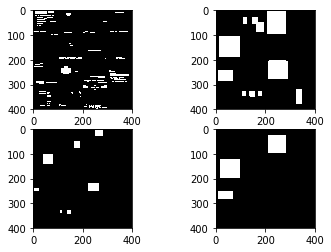

In [57]:
%matplotlib inline
import math
test_images = test_image_manager.next_batch(16)[:, :, :, :NUM_BYTES_FOR_MASK]
test_images = test_images.reshape(test_images.shape[0], -1).astype(np.float16)
canvas_recon = np.zeros((100 * 4, 100 * 4, NUM_BYTES_FOR_MASK))
for j in range(16):
    # Draw the generated digits 
    x = j//4
    y = j%4
#         print(test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK]).shape)
#         print(test_images[j].shape)
    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                 (x + 1) * 100,:] = test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
f, axarr = plt.subplots(2,2)

for i in range(NUM_BYTES_FOR_MASK):
    axarr[i//2][i%2].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
# plt.show()
# plt.tight_layout()

<IPython.core.display.Javascript object>


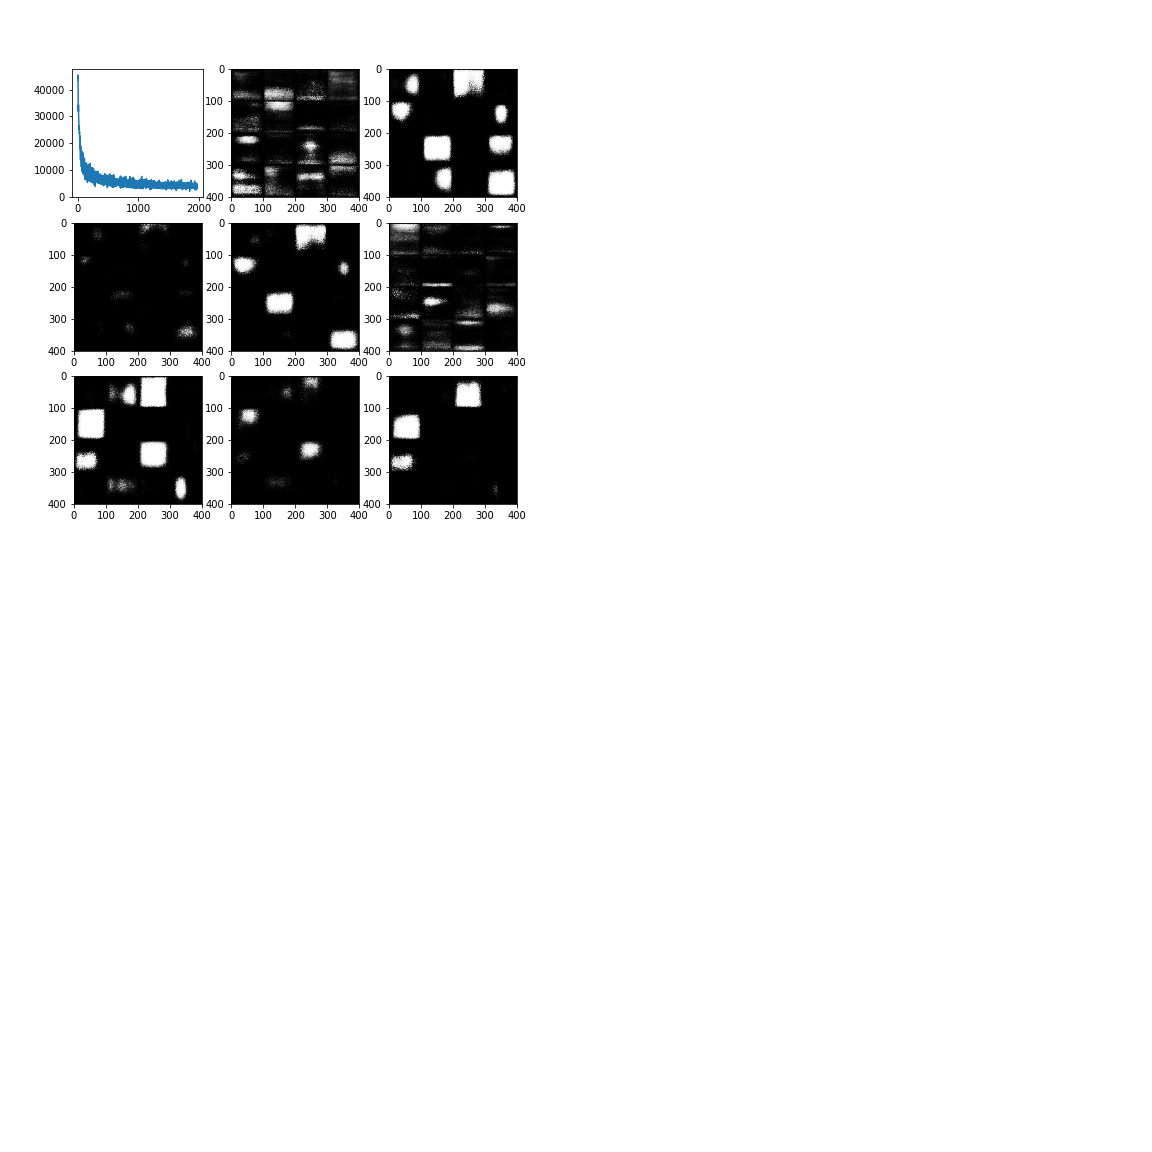

A Jupyter Widget


Saved model at: /gpfs/scratch/asamanta/models/vae_1024_128_16_sigmoid_adam/model.ckpt
37.0286251677
Original Images vs Reconstructed Images
Layer: 0


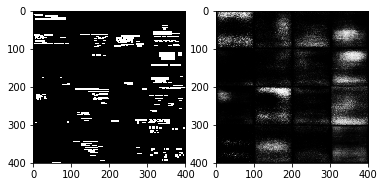

Layer: 1


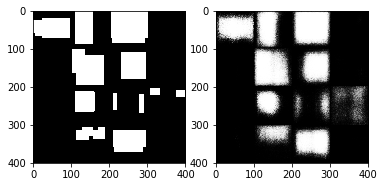

Layer: 2


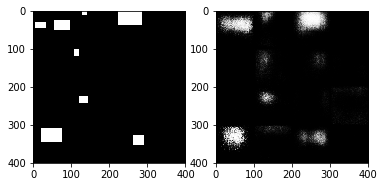

Layer: 3


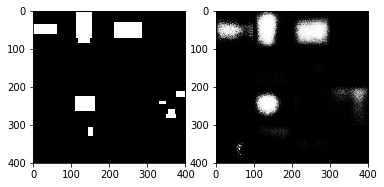

[3485.5042]


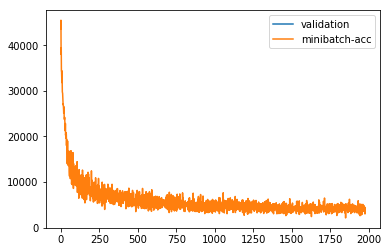

CPU times: user 7min 2s, sys: 20 s, total: 7min 22s
Wall time: 7min 46s


In [58]:
%%time
%matplotlib notebook
# Start Training
# Start a new TF session
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
batch_loss_plot = []
test_loss_plot = []
with tf.Session() as sess:


    # Run the initializer
    sess.run(init)
    
    saver = tf.train.Saver()

    fig,ax = plt.subplots(3,3,figsize=(8,8))
#     plt.ion()
    
    for k in range(NUM_BYTES_FOR_MASK):
        ax[(k+5)//3][(k+5)%3].clear()
        ax[(k+5)//3][(k+5)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
    
#     fig.show()
    fig.canvas.draw()
    # Training
    for i in tqdm_notebook(range(num_steps)):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        avg_loss = 0.
        total_batch = n_samples // batch_size
#         total_batch = 2000
        
        # Loop over all batches
        for j in range(total_batch):
            batch_x = image_manager.next_batch(batch_size)
            batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
            batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
            # Train
            feed_dict = {input_image: batch_x}
            _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
            avg_loss += l / n_samples * batch_size
            batch_loss_plot.append(l)
            ax[0][0].clear()
            ax[0][0].plot(batch_loss_plot[-total_batch:])
            if (j%(total_batch//5))==0:
                g = decoder.eval(feed_dict={input_image: batch_x})
                for k in range(16):
                    # Draw the generated digits 
                    x = k//4
                    y = k%4
                    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                                 (x + 1) * 100,:] = g[k].reshape([100, 100, NUM_BYTES_FOR_MASK])
                for k in range(4):
                    ax[(k+1)//3][(k+1)%3].clear()
                    ax[(k+1)//3][(k+1)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
            fig.canvas.draw()
        
        validation_error = loss_op.eval(feed_dict={input_image: test_images})
        
        g = decoder.eval(feed_dict={input_image: test_images})
        for j in range(16):
            # Draw the generated digits 
            x = j//4
            y = j%4
            canvas_recon[y * 100:(y + 1) * 100, x * 100:
                         (x + 1) * 100,:] = g[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
        for k in range(NUM_BYTES_FOR_MASK):
            ax[(k+5)//3][(k+5)%3].clear()
            ax[(k+5)//3][(k+5)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
            fig.canvas.draw()
    
        test_loss_plot.append(validation_error)
    model_name = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])+'/model.ckpt'
    save_path = saver.save(sess, model_name)
    
    export_dir = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])
    inputs = {'input': input_image}
    outputs = {'output': decoder}
    print('Saved model at:', save_path)

    image_test_and_plot(image_manager, sess)
    print(test_loss_plot)
    
    p = plt.figure()
    plt.plot(test_loss_plot, label='validation')
    plt.plot(batch_loss_plot, label='minibatch-acc')
    plt.legend()
    plt.show()

## Restore session from saved model

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_128_32_sigmoid_adam/model.ckpt
(4, 40000)
(4, 40000)
(4, 40000)
(4, 40000)
115.308187117
Original Images vs Reconstructed Images
Layer: 0


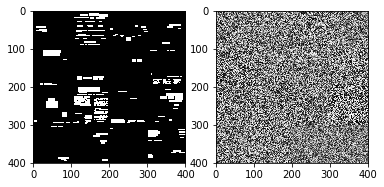

Layer: 1


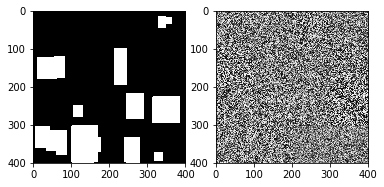

Layer: 2


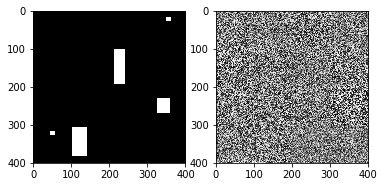

Layer: 3


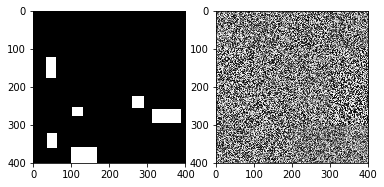

In [29]:
MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_128_32_sigmoid_adam/'
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    image_test_and_plot(test_image_manager, sess)

# TENSORFLOW Autoencoder implementation

In [ ]:
# Parameters
learning_rate = 0.001
num_steps = 20
batch_size = 50

# Network Parameters
image_dim = 100*100*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 1024
hidden_dim2 = 256
latent_dim = 128
vae =  VariationalAutoencoder(
    n_input=image_dim,
    n_hidden=hidden_dim1,
    optimizer=tf.train.AdamOptimizer(learning_rate = 0.001))

In [ ]:
n_samples = image_manager.files.shape[0]
display_step = 5
for epoch in range(num_steps+1):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x = image_manager.next_batch(batch_size)
        batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)*1.0/255.0
        print(np.max(batch_x))
        # Fit training using batch data
        cost = vae.partial_fit(batch_x)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%d,' % (epoch + 1),
              "Cost:", "{:.9f}".format(avg_cost))

In [ ]:
batch_x = image_manager.next_batch(4278)
batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)*1.0/255.0
print(np.max(batch_x))

## Run only once

In [25]:
def open_and_resize(file_names, folder_path):
    images = np.array([cv2.resize(cv2.imread(os.path.join(folder_path, file_name), 0), (100, 100)) 
                for file_name in file_names])
    images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])
    # Converting from [0, 255] -> [0.0, 1.0].
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    return images

file_names = os.listdir(test_folder)
resized_images = open_and_resize(file_names, test_folder)
print (resized_images.shape)

new_files = os.listdir(mask_folder)
new_images = open_and_resize(new_files, mask_folder)
print (new_images.shape)

file_names.extend(new_files)
resized_images = np.append(resized_images, new_images, axis=0)
print (resized_images.shape)

(5599, 10000)
(11190, 10000)
(16789, 10000)


In [27]:
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver.restore(sess, 'models/vae_2048_256_64_sigmoid_adam/model.ckpt')
    encoded_images = sess.run(encoder, feed_dict={input_image: resized_images})
# encoded_images = model.transform(resized_images)
print (encoded_images.shape)

INFO:tensorflow:Restoring parameters from models/vae_2048_256_64_sigmoid_adam/model.ckpt
(16789, 256)


## Similarity Match

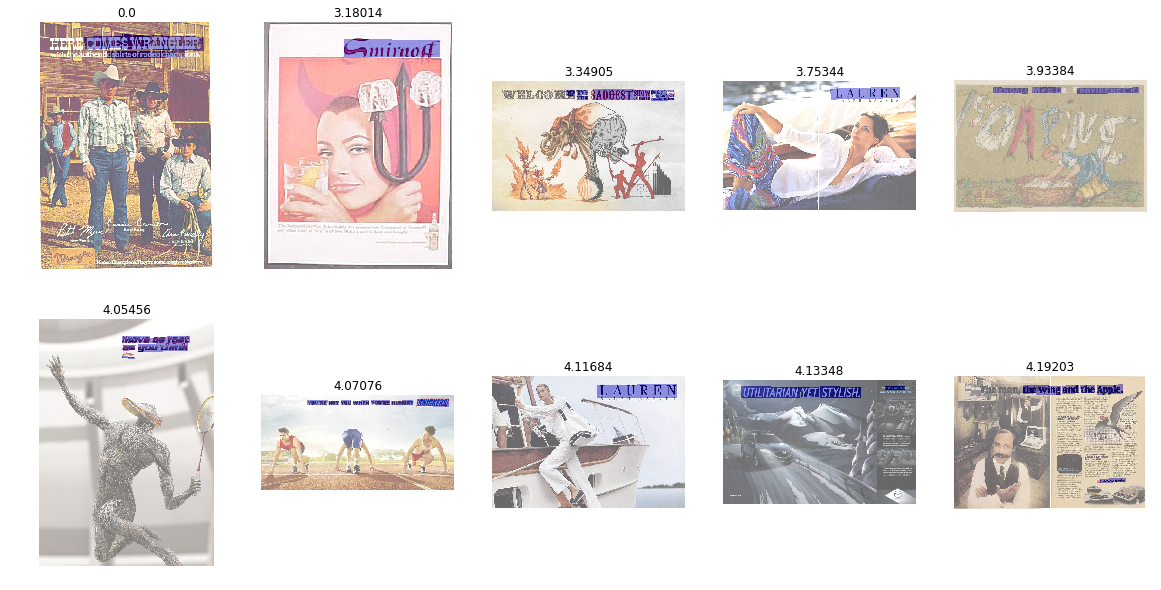

In [32]:
from sklearn.neighbors import KDTree
from skimage.measure import compare_ssim as ssim

# print (resized_images.shape)

# kdt = KDTree(encoded_images, leaf_size=100, metric='euclidean')
# nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(encoded_images)

random_idx = np.random.randint(len(resized_images))
# random_idx = 6528
encoded_random_img = encoded_images[random_idx]
# print (random_idx, encoded_random_img.shape)

# indices = kdt.query(encoded_random_img, k=10, return_distance=False)
# distances, indices = nbrs.kneighbors(np.array([encoded_random_img]))
# print (indices)

def getDistance(src_img, dst_img):
#     return 1 - ssim(src_img, dst_img, full=True)[0]
#     return 1 - ssim(src_img, dst_img, data_range=dst_img.max() - dst_img.min())
    return np.linalg.norm(src_img - dst_img)

distances = []
for i in range(len(encoded_images)):
    distance = getDistance(encoded_images[i], encoded_random_img)
    distances.append((distance, i))

distances.sort()
# print (distances)

fig = plt.figure(figsize=(20, 10))
for i in range(10):
    file_index = distances[i][1]
#     print (distances[i][0], np.linalg.norm(encoded_images[file_index] - encoded_random_img))
    if os.path.exists(os.path.join(test_folder, file_names[file_index])):
#         display(Image(filename=os.path.join(test_folder, file_names[file_index]), width=200, height=200))
        mask_img = cv2.imread(filename=os.path.join(test_folder, file_names[file_index]))
    else:
#         display(Image(filename=os.path.join(mask_folder, file_names[file_index]), width=200, height=200))        
        mask_img = cv2.imread(filename=os.path.join(mask_folder, file_names[file_index]))
#     display(Image(filename=os.path.join(image_folder, file_names[file_index]), width=200, height=200))
    main_img = cv2.imread(os.path.join(image_folder, file_names[file_index]))
#     show(cv2.add(cv2.bitwise_not(mask_img), 200))
#     show(main_img)
    p = fig.add_subplot(2, 5, i + 1)
    p.set_title(distances[i][0])
    final_img = cv2.addWeighted(main_img, 0.6, cv2.add(cv2.bitwise_not(mask_img), 200), 0.4, 0.6)
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
#     plt.subplot(cv2.addWeighted(main_img, 0.6, cv2.add(cv2.bitwise_not(mask_img), 200), 0.4, 0.6))

plt.show()

# DENOISING AUTOENCODER

In [72]:
from deepautoencoder import StackedAutoEncoder
X = image_manager.next_batch(10000)
X_test = test_image_manager.next_batch(1500)
print(X.shape)
print(X_test.shape)
model = StackedAutoEncoder(dims=[2048, 128], activations=['relu', 'relu'], noise='gaussian', epoch=[2048, 128],
                            loss='rmse', lr=0.007, batch_size=50, print_step=100)
# usage 2 - fitting on one dataset and transforming (encoding) on another data
model.fit(X)
result = model.transform(X_test)

(10000, 10000)
(1440, 10000)
Layer 1
epoch 99: global loss = 116.11784362792969
epoch 199: global loss = 87.89913177490234
epoch 299: global loss = 66.70242309570312
epoch 399: global loss = 50.395870208740234
epoch 499: global loss = 38.164154052734375
epoch 599: global loss = 28.80917739868164
epoch 699: global loss = 21.613500595092773
epoch 799: global loss = 17.40351676940918
epoch 899: global loss = 12.881658554077148
epoch 999: global loss = 10.738313674926758
epoch 1099: global loss = 5.836661338806152
epoch 1199: global loss = 4.762335300445557
epoch 1299: global loss = 4.268123626708984
epoch 1399: global loss = 1.4102522134780884
epoch 1499: global loss = 1.3181167840957642
epoch 1599: global loss = 0.679833173751831
epoch 1699: global loss = 0.5468035340309143
epoch 1799: global loss = 0.518040120601654
epoch 1899: global loss = 0.5081227421760559
epoch 1999: global loss = 0.4832223951816559
Layer 2
epoch 99: global loss = 20.546905517578125


In [76]:
t = model.activate(result, 'relu')

In [ ]:
wi

# Using AutoEncoder

In [22]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

dim_ = 100
display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)

# num_hidden_1 = 2048 # 1st layer num features
# num_hidden_2 = 256 # 2nd layer num features (the latent dim)
# num_hidden_3 = 64
num_input = dim_ * dim_ # data input (img shape: 100*100)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
#     'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3])),
#     'decoder_h1': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
#     'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
#     'decoder_b1': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [23]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
#     layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
#                                    biases['encoder_b3']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
#     layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
#                                    biases['decoder_b3']))    
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [24]:
# image_manager = ImageManager(mask_folder)

In [25]:
%%time
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x = image_manager.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))


Step 1: Minibatch Loss: 0.464871
Step 1000: Minibatch Loss: 0.125284
Step 2000: Minibatch Loss: 0.117423
Step 3000: Minibatch Loss: 0.126035
Step 4000: Minibatch Loss: 0.116182
Step 5000: Minibatch Loss: 0.118330
Step 6000: Minibatch Loss: 0.111889
Step 7000: Minibatch Loss: 0.122504
Step 8000: Minibatch Loss: 0.109259
Step 9000: Minibatch Loss: 0.114194
Step 10000: Minibatch Loss: 0.114798
Step 11000: Minibatch Loss: 0.112317


KeyboardInterrupt: 

In [29]:
saver = tf.train.Saver()
save_path = saver.save(sess, "models/2_layer_256_128_sigmoid_rms.ckpt")

Original Images


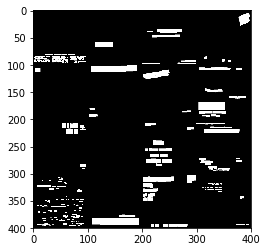

Reconstructed Images


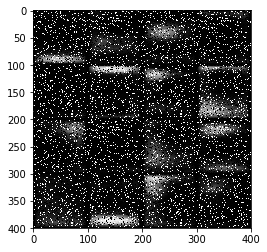

In [68]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((dim_ * n, dim_ * n))
canvas_recon = np.empty((dim_ * n, dim_ * n))
for i in range(n):
    # Image test set
    batch_x = image_manager.next_batch(n)
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={X: batch_x})
    
    # Display original images
    for j in range(n):
#         print (batch_x[j])
        # Draw the generated digits
        canvas_orig[i * dim_:(i + 1) * dim_, j * dim_:(j + 1) * dim_] = batch_x[j].reshape([dim_, dim_])

#     print (np.max(g[0]))
    # Display reconstructed images
    for j in range(n):
        # Draw the generated digits
        canvas_recon[i * dim_:(i + 1) * dim_, j * dim_:(j + 1) * dim_] = g[j].reshape([dim_, dim_])

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

In [43]:
def open_and_resize(file_names, folder_path):
    images = np.array([cv2.resize(cv2.imread(os.path.join(folder_path, file_name), 0), (100, 100)) 
                for file_name in file_names])
    images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])
    # Converting from [0, 255] -> [0.0, 1.0].
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    return images

# file_names = os.listdir(mask_folder)
# resized_images = open_and_resize(file_names, mask_folder)

In [44]:
encoded_images = sess.run(encoder_op, feed_dict={X: resized_images})

In [45]:
print (encoded_images.shape)
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(encoded_images)

(5673, 128)


In [65]:
random_idx = np.random.randint(len(resized_images))
encoded_random_img = sess.run(encoder_op, feed_dict={X: [resized_images[random_idx]]})

distances, indices = nbrs.kneighbors(np.array(encoded_random_img))
print (indices)

[[4710  244 1346 2160 3069 5091 4584 4846  200 1578]]


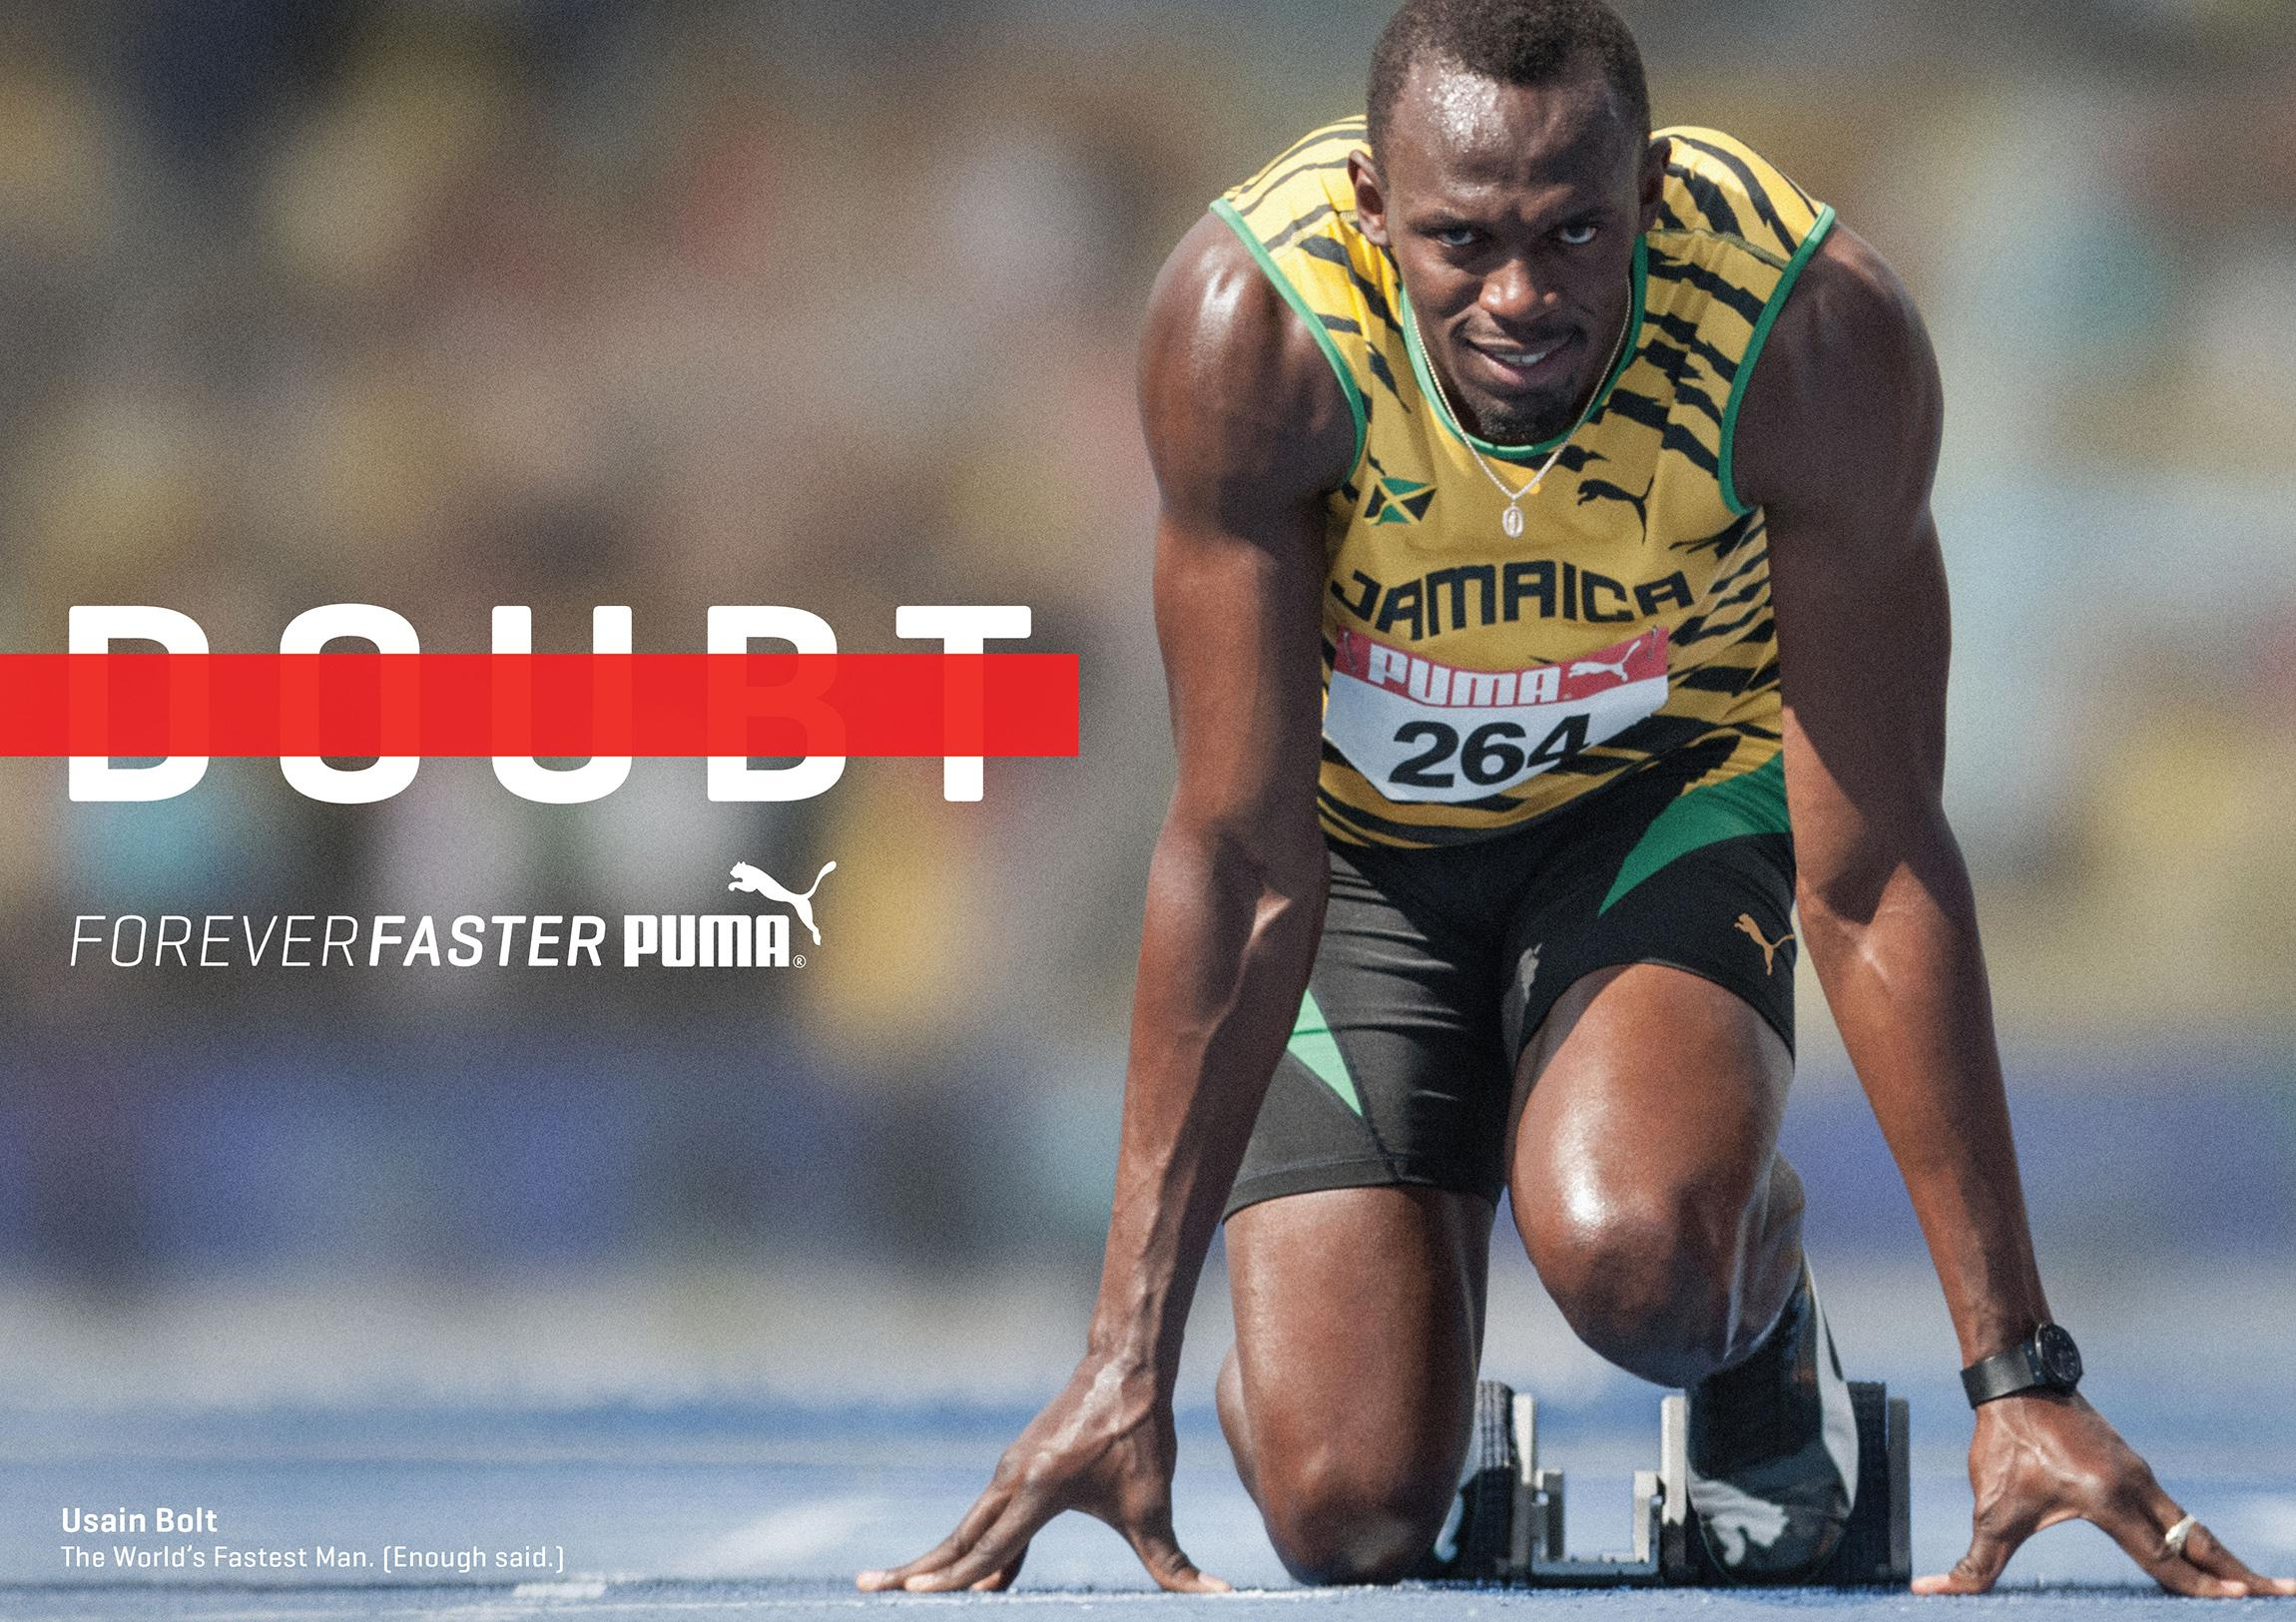

In [66]:
display(Image(filename=os.path.join(image_folder, file_names[random_idx]), width=200, height=200))

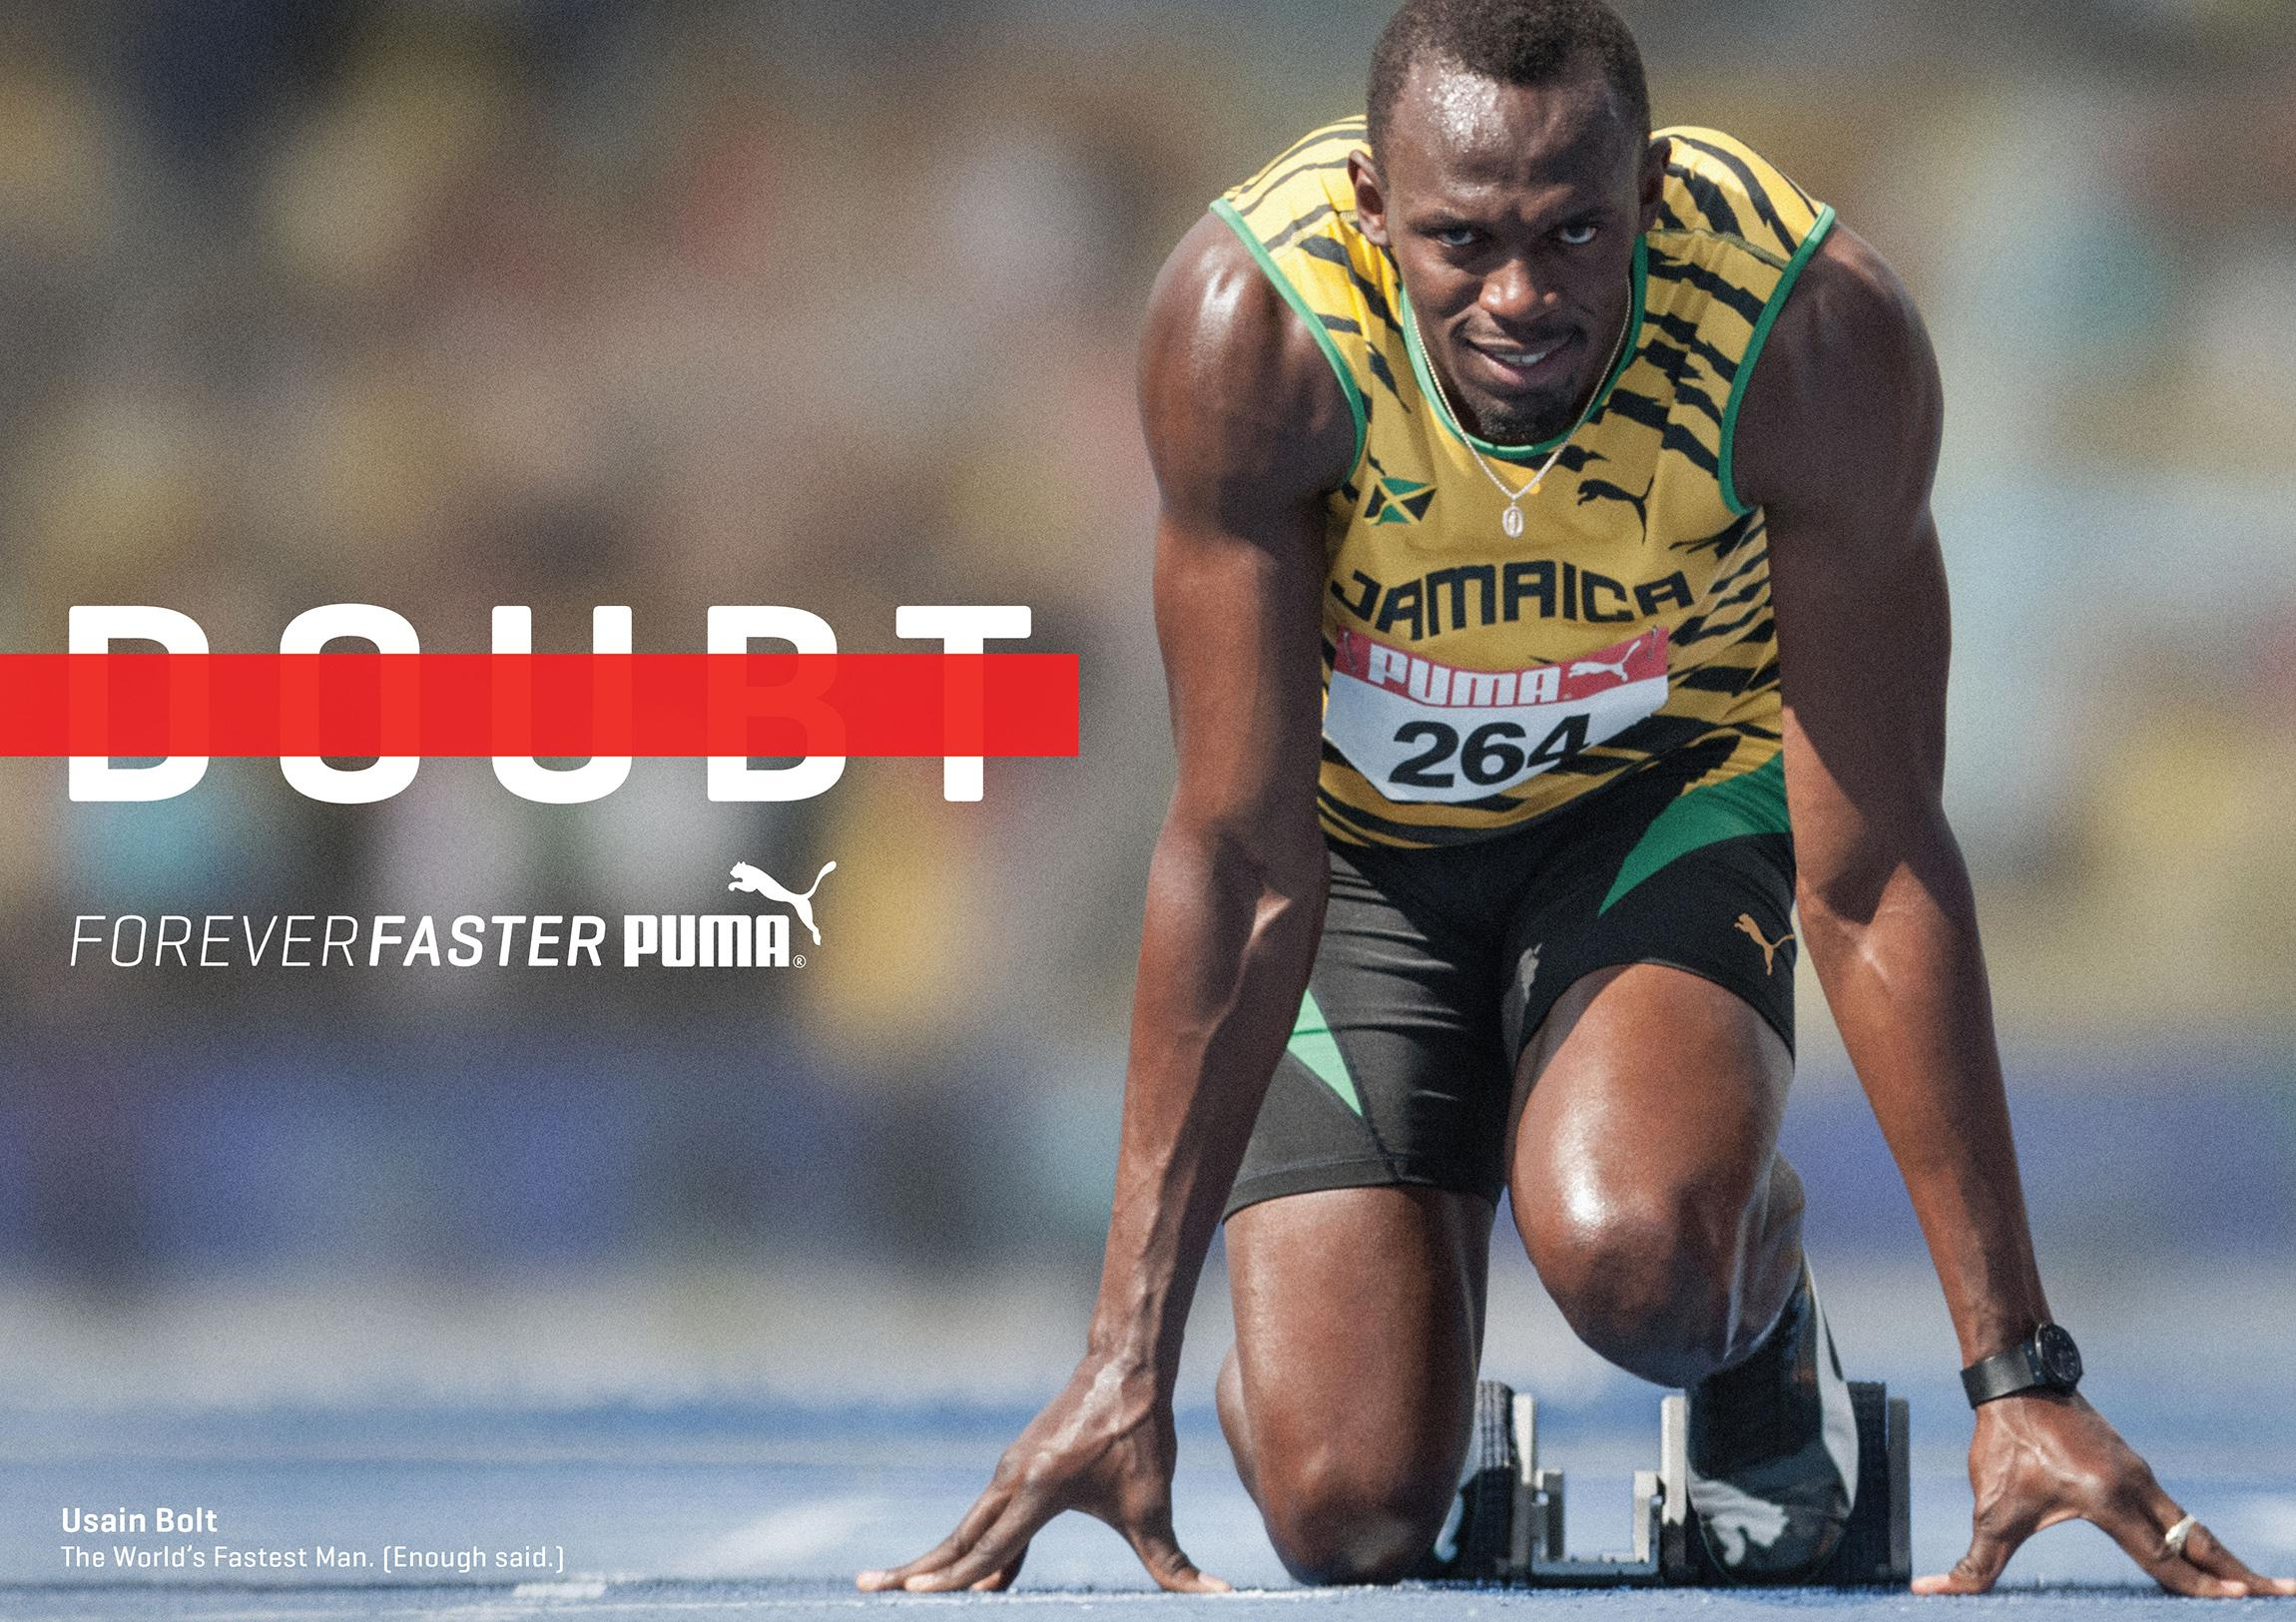

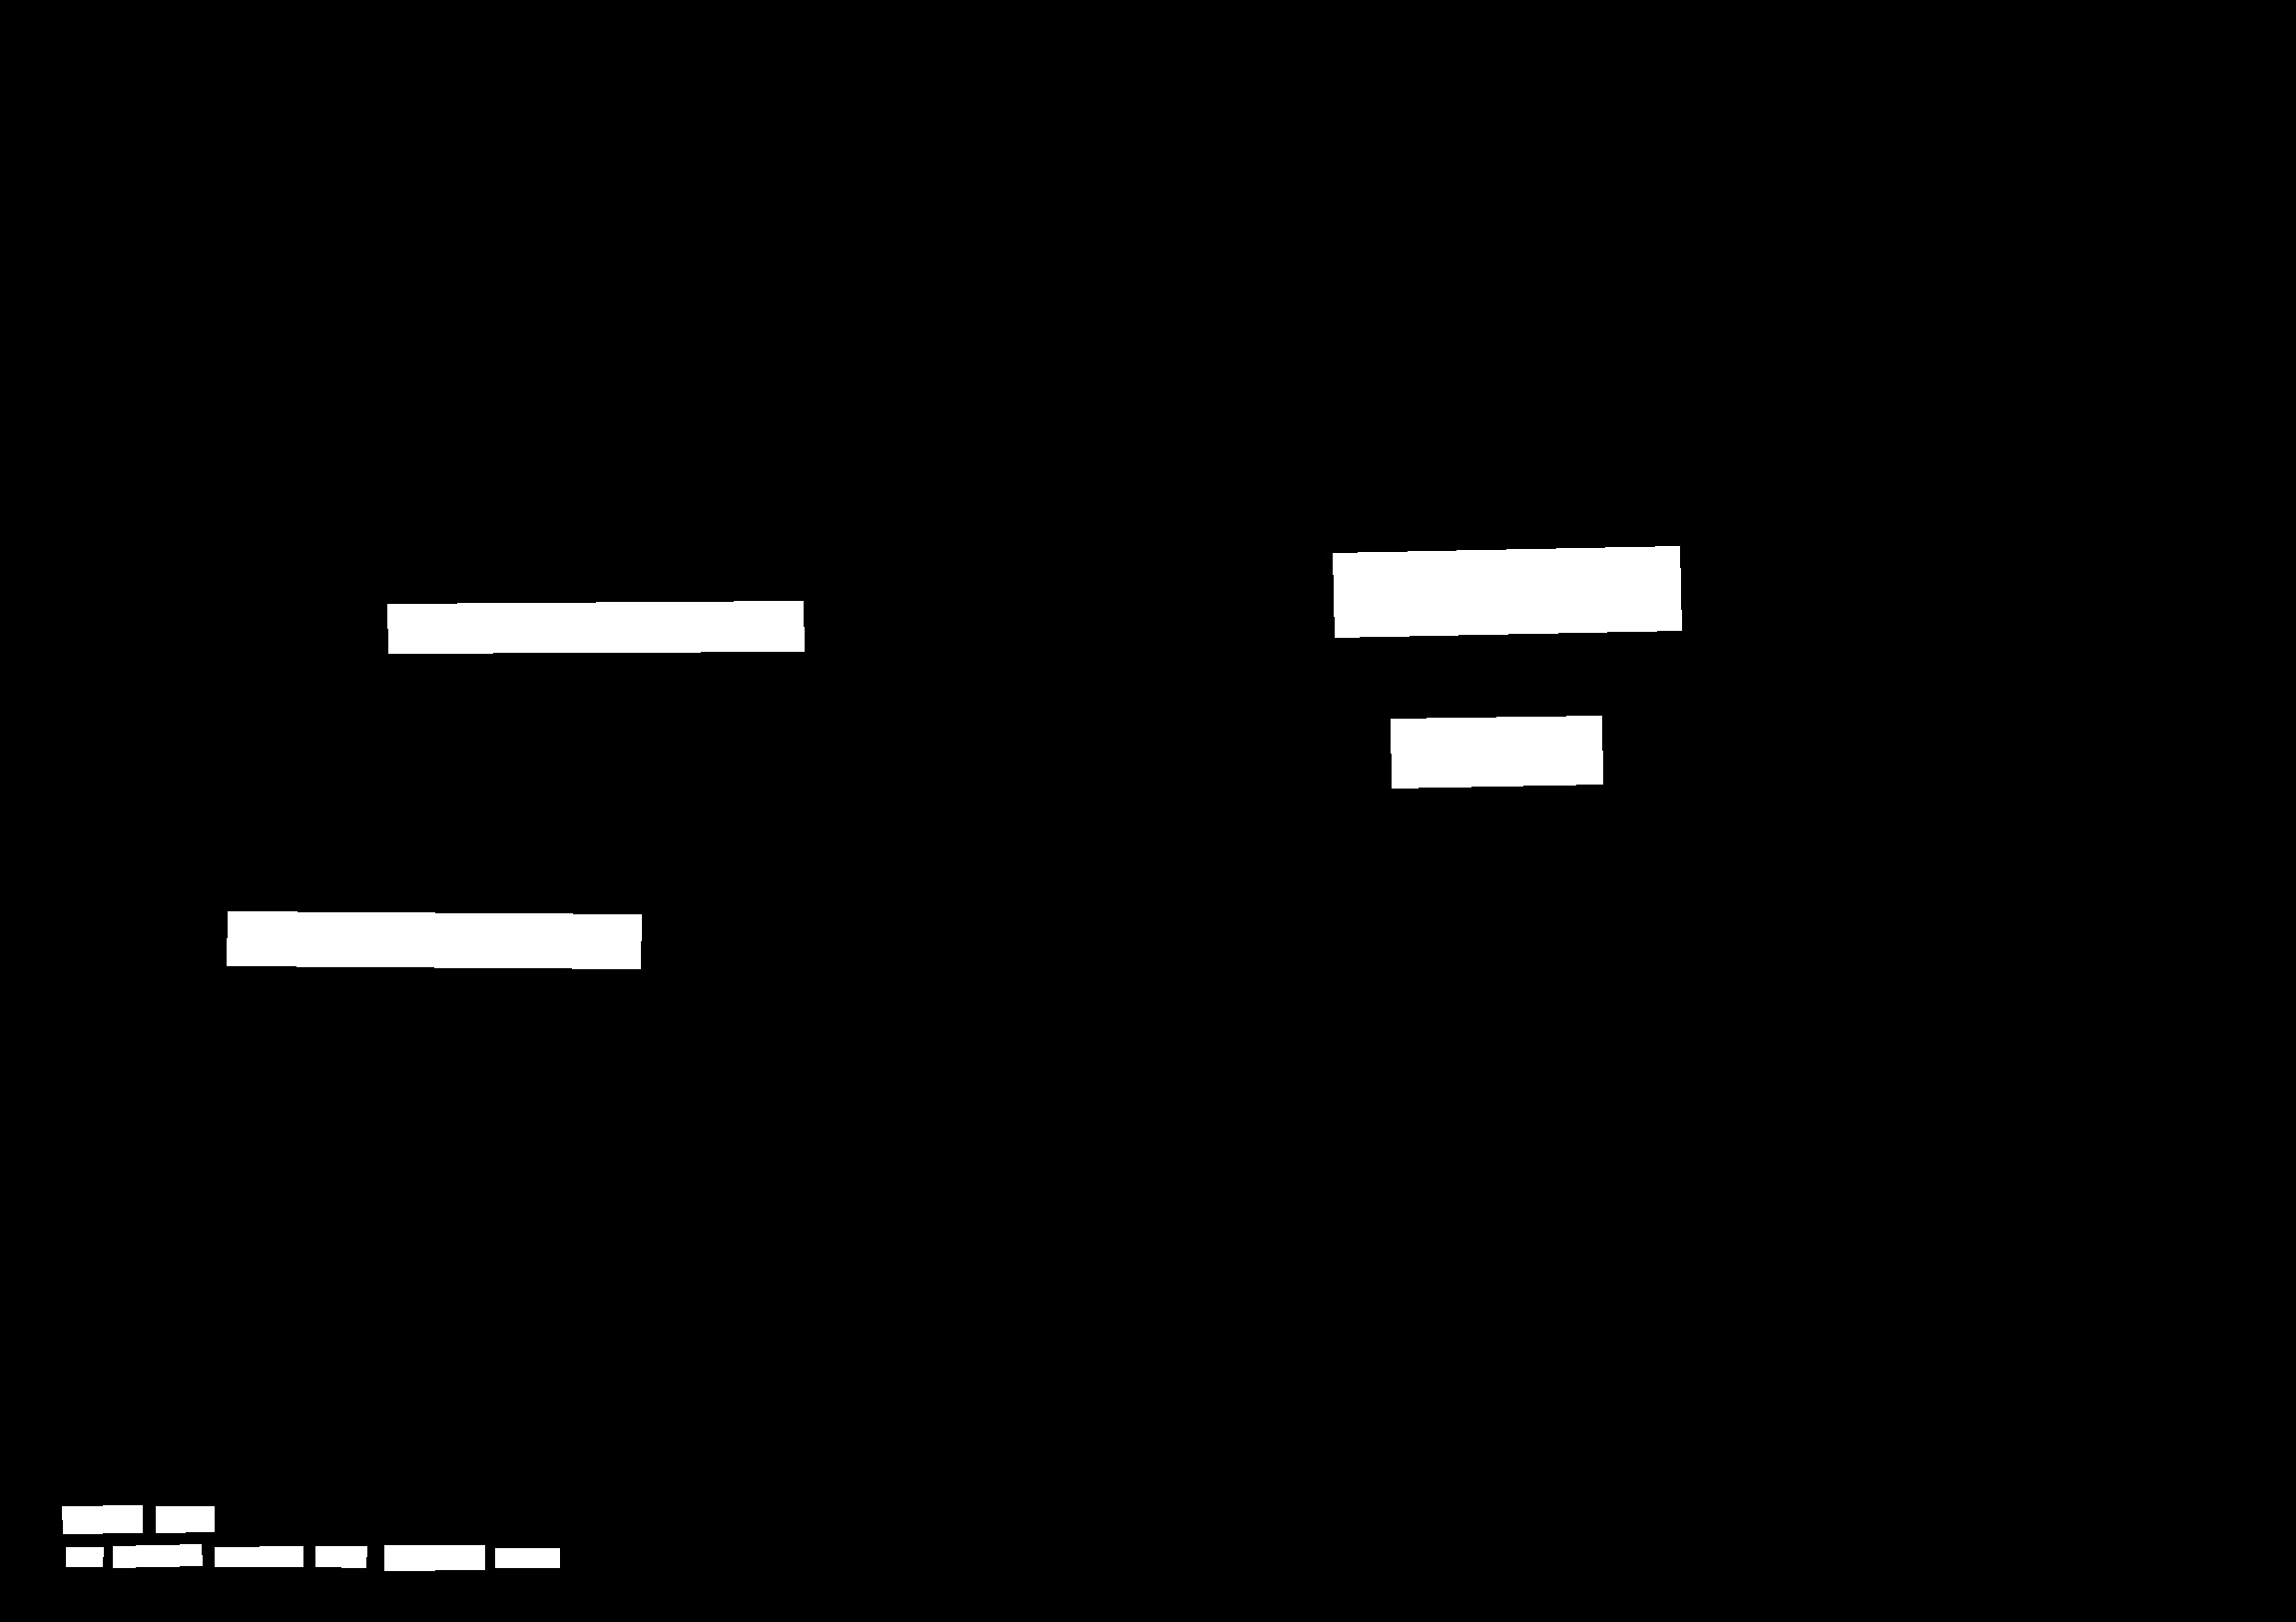

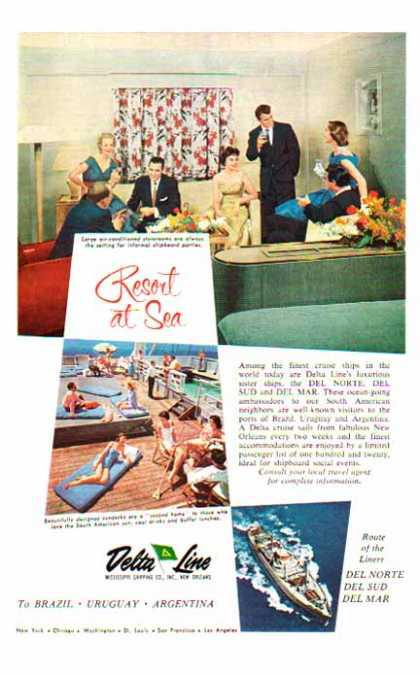

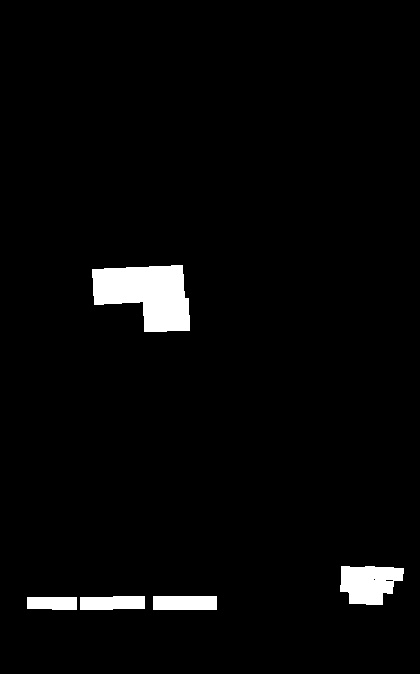

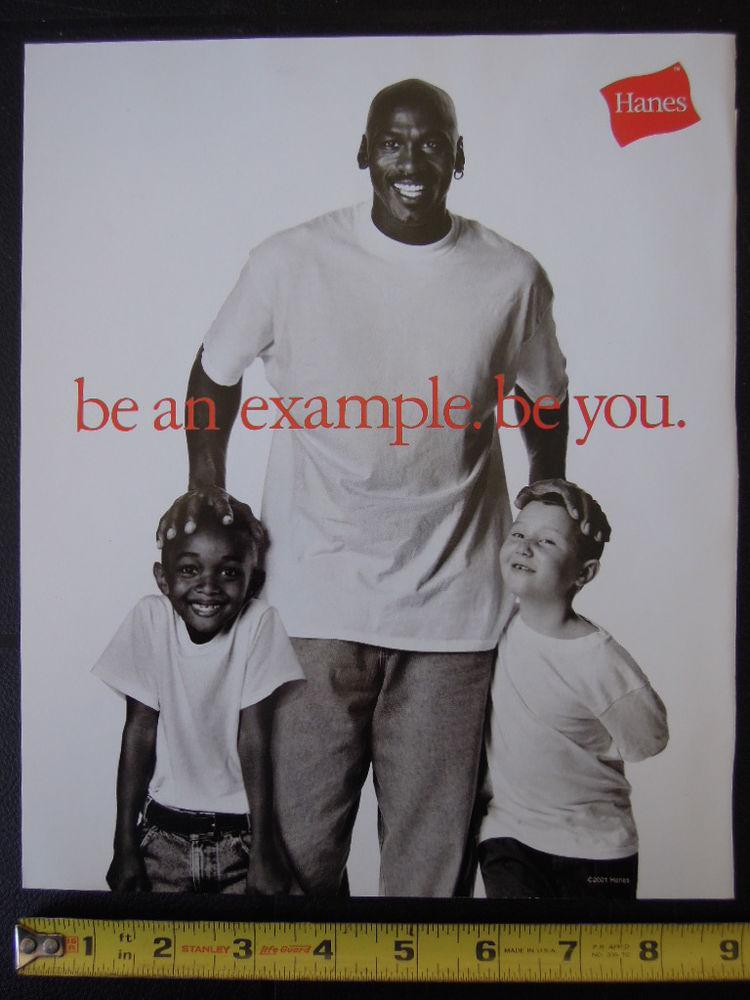

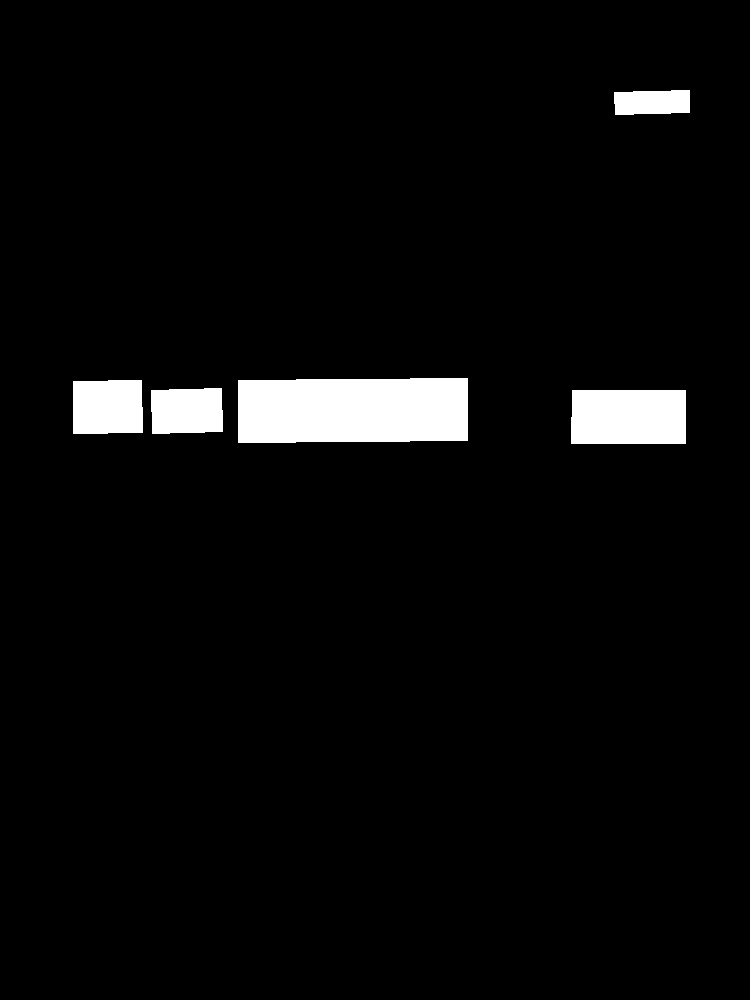

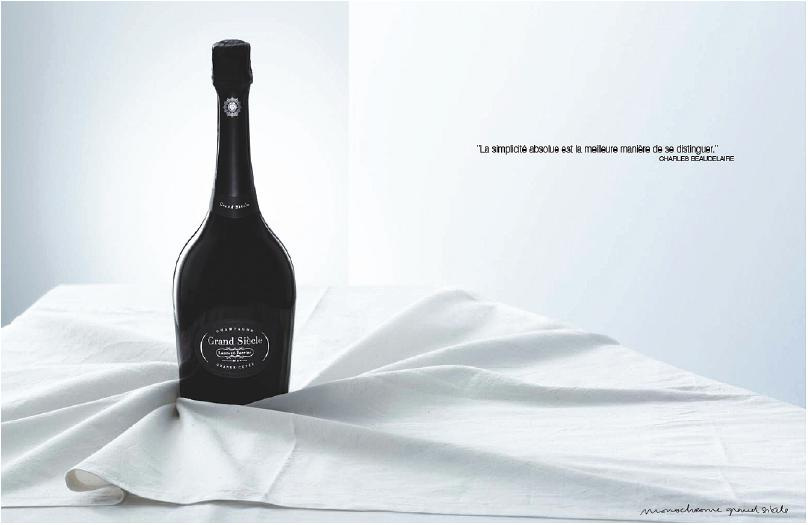

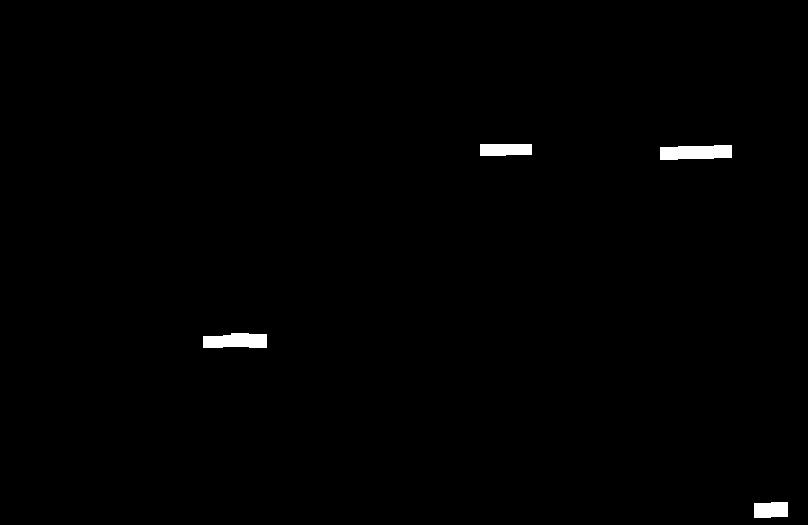

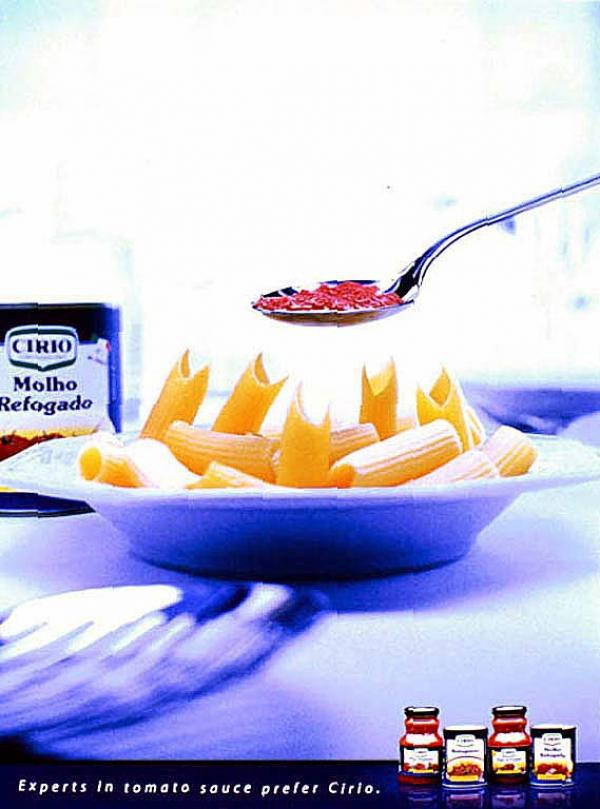

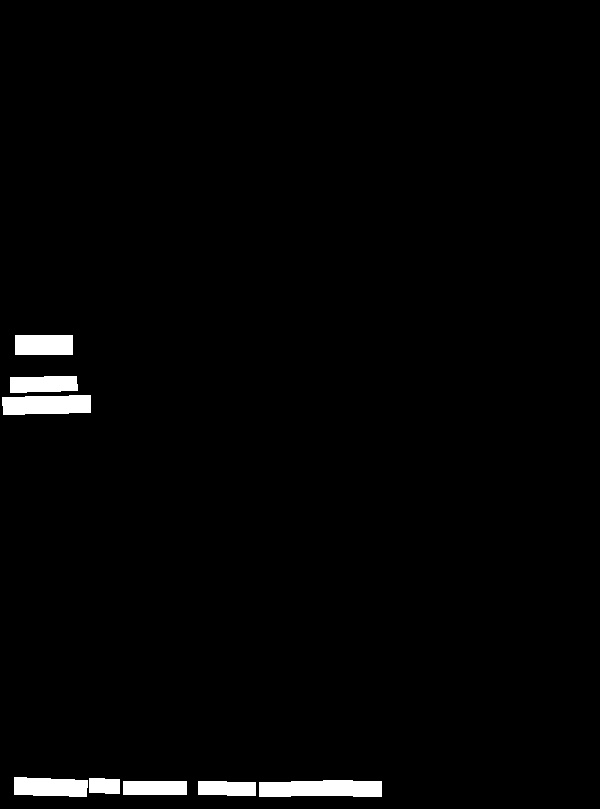

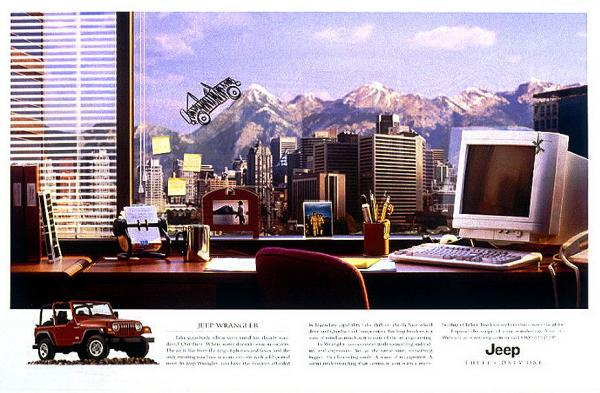

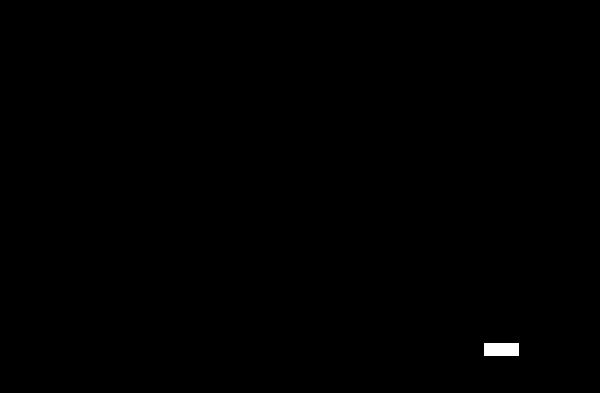

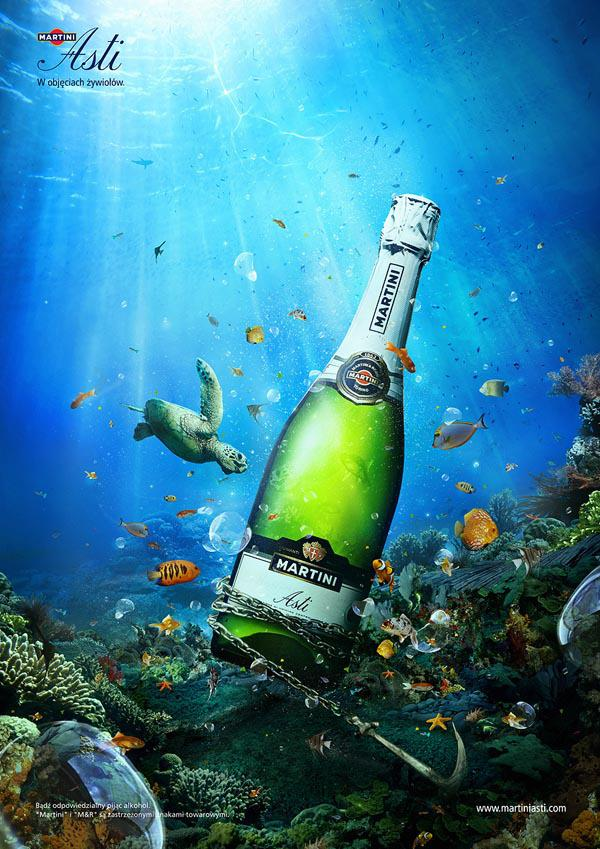

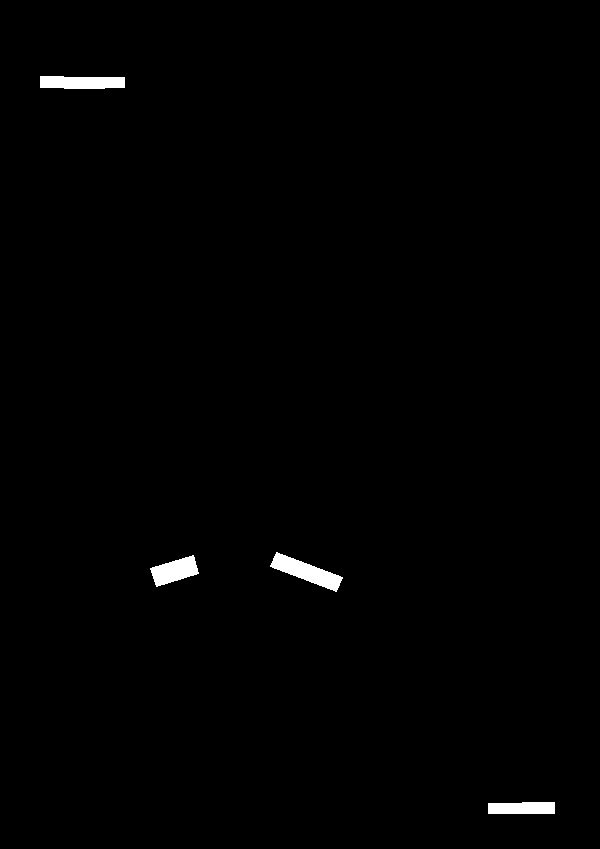

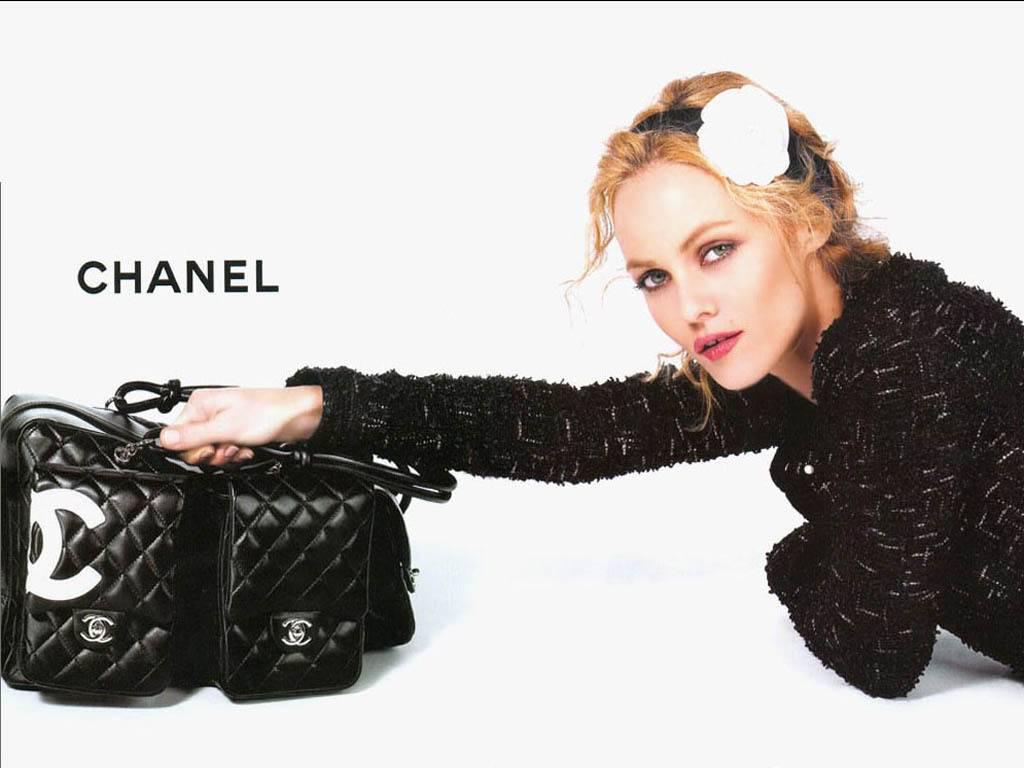

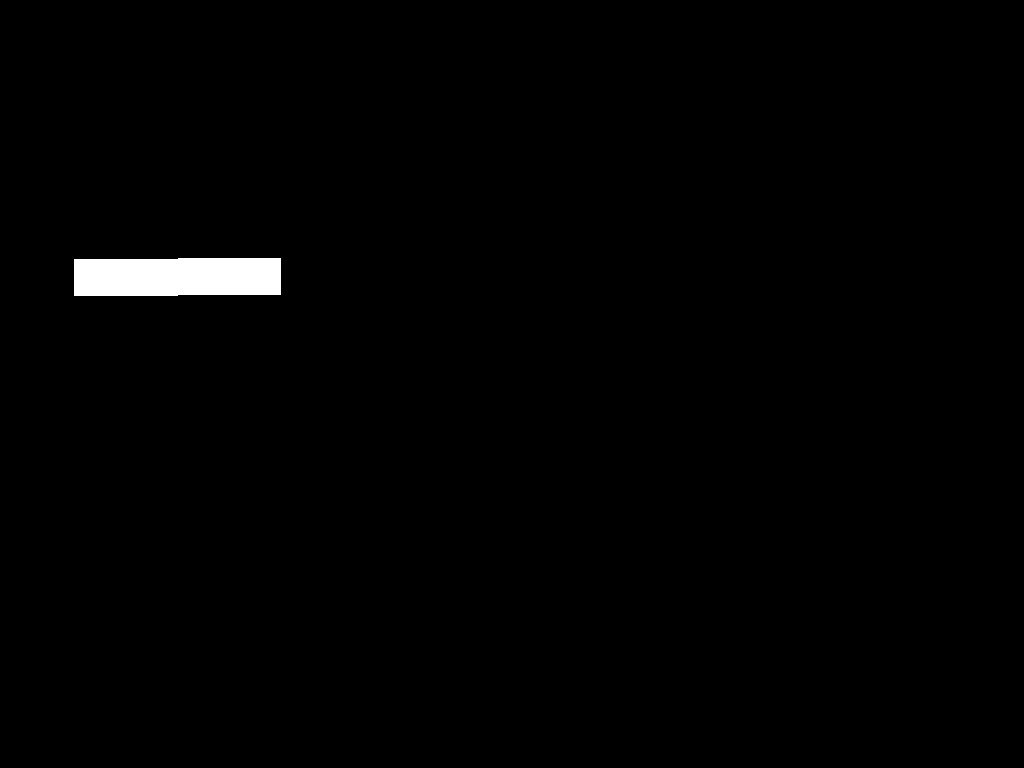

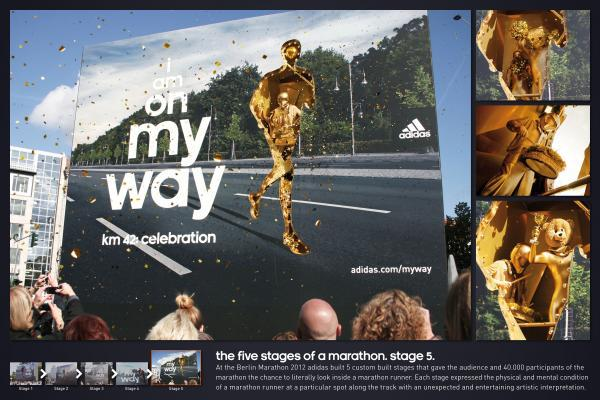

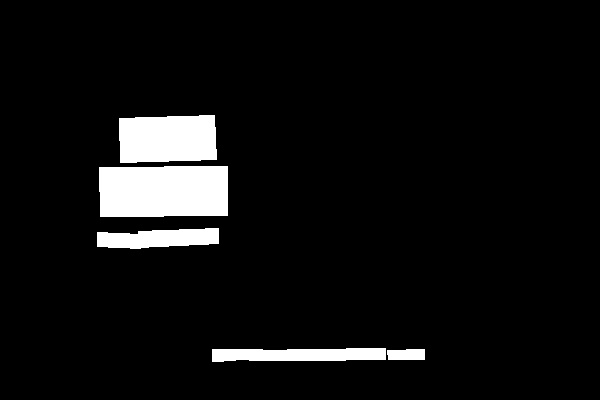

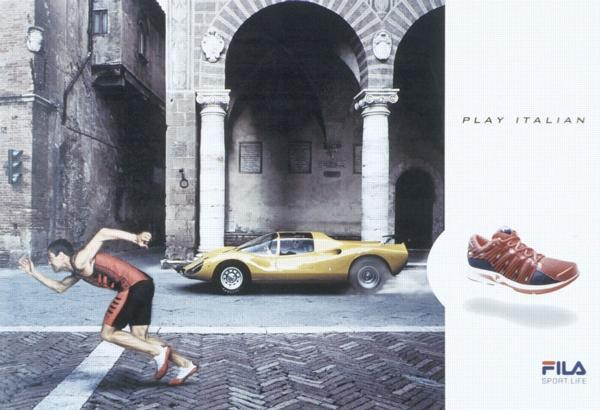

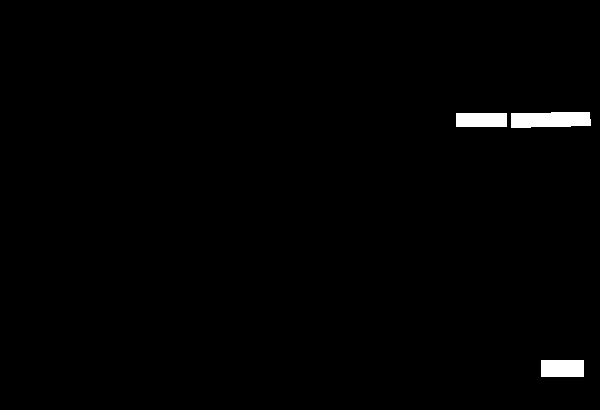

In [67]:
for file_index in indices[0]:
    display(Image(filename=os.path.join(image_folder, file_names[file_index]), width=200, height=200))
    display(Image(filename=os.path.join(mask_folder, file_names[file_index]), width=200, height=200))